In [319]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
import lightgbm as lgb

In [320]:
train_df = pd.read_csv('flight_delays_train.csv')
test_df = pd.read_csv('flight_delays_test.csv')

In [321]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [341]:
train_df['dep_delayed_15min'].value_counts()

N    80956
Y    19044
Name: dep_delayed_15min, dtype: int64

#### feature engineering

In [322]:
train_df['flight'] = train_df['Origin'] + '-->' + train_df['Dest']

test_df['flight'] = test_df['Origin'] + '-->' + test_df['Dest']

In [323]:
train_df['UniqueCarrier_Route'] = train_df['UniqueCarrier'] + "_" + train_df['flight']

test_df['UniqueCarrier_Route'] = test_df['UniqueCarrier'] + '-->' + test_df['flight']

In [324]:
train_df['dep_origin'] = (train_df['DepTime'] // 100).apply(str) + "_" + train_df['Origin']

test_df['dep_origin'] = (test_df['DepTime'] // 100).apply(str) + "_" + test_df['Origin']

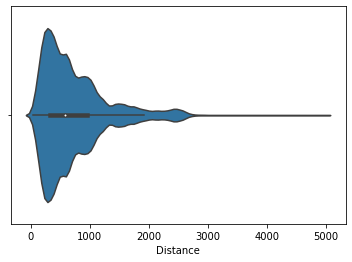

In [325]:
import seaborn as sns
ax = sns.violinplot(x=train_df["Distance"])

In [326]:
train_df['Dist_bin'] = 0
train_df.loc[train_df.Distance <= 500, 'Dist_bin'] = 'vshort'
train_df.loc[(train_df.Distance > 500) & (train_df.Distance <= 1000), 'Dist_bin'] = 'short'
train_df.loc[(train_df.Distance > 1000) & (train_df.Distance <= 1500), 'Dist_bin'] = 'lshort'
train_df.loc[(train_df.Distance > 1500) & (train_df.Distance <= 2000), 'Dist_bin'] = 'mid'
train_df.loc[(train_df.Distance > 2000) & (train_df.Distance <= 2500), 'Dist_bin'] = 'long'
train_df.loc[train_df.Distance > 2500, 'Dist_bin'] = 'vlong'

test_df['Dist_bin'] = 0
test_df.loc[test_df.Distance <= 500, 'Dist_bin'] = 'vshort'
test_df.loc[(test_df.Distance > 500) & (test_df.Distance <= 1000), 'Dist_bin'] = 'short'
test_df.loc[(test_df.Distance > 1000) & (test_df.Distance <= 1500), 'Dist_bin'] = 'lshort'
test_df.loc[(test_df.Distance > 1500) & (test_df.Distance <= 2000), 'Dist_bin'] = 'mid'
test_df.loc[(test_df.Distance > 2000) & (test_df.Distance <= 2500), 'Dist_bin'] = 'long'
test_df.loc[test_df.Distance > 2500, 'Dist_bin'] = 'vlong'

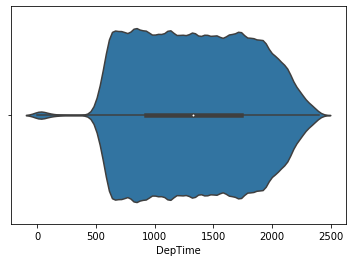

In [327]:
ax = sns.violinplot(x=test_df["DepTime"])

In [328]:
train_df.loc[train_df.DepTime <= 600 , 'DepTime_bin'] = 'Night'
train_df.loc[(train_df.DepTime > 600) & (train_df.DepTime <= 1200), 'DepTime_bin'] = 'Morning'
train_df.loc[(train_df.DepTime > 1200) & (train_df.DepTime <= 1800), 'DepTime_bin'] = 'Afternoon'
train_df.loc[(train_df.DepTime > 1800) & (train_df.DepTime <= 2600), 'DepTime_bin'] = 'Evening'

test_df.loc[test_df.DepTime <= 600 , 'DepTime_bin'] = 'Night'
test_df.loc[(test_df.DepTime > 600) & (test_df.DepTime <= 1200), 'DepTime_bin'] = 'Morning'
test_df.loc[(test_df.DepTime > 1200) & (test_df.DepTime <= 1800), 'DepTime_bin'] = 'Afternoon'
test_df.loc[(test_df.DepTime > 1800) & (test_df.DepTime <= 2600), 'DepTime_bin'] = 'Evening'

In [329]:
train_df[train_df['dep_delayed_15min'] == "Y"]['DepTime_bin'].value_counts()

Afternoon    7879
Evening      7342
Morning      3577
Night         246
Name: DepTime_bin, dtype: int64

In [371]:
train_df['density'] = train_df.Month.str.slice(start=2).apply(str)  + "_" + train_df.DayofMonth.str.slice(start=2).apply(str)  + "_" + train_df['UniqueCarrier']

test_df['density'] = test_df.Month.str.slice(start=2).apply(str)  + "_" + test_df.DayofMonth.str.slice(start=2).apply(str)  + "_" + test_df['UniqueCarrier']

In [372]:
train_df['density_origin'] = train_df.Month.str.slice(start=2).apply(str)  + "_" + train_df.DayofMonth.str.slice(start=2).apply(str)  + "_" + train_df['Origin']
test_df['density_origin'] = test_df.Month.str.slice(start=2).apply(str)  + "_" + test_df.DayofMonth.str.slice(start=2).apply(str)  + "_" + test_df['Origin']

In [373]:
train_df['density_dest'] = train_df.Month.str.slice(start=2).apply(str)  + "_" + train_df.DayofMonth.str.slice(start=2).apply(str)  + "_" + train_df['Dest']

test_df['density_dest'] = test_df.Month.str.slice(start=2).apply(str)  + "_" + test_df.DayofMonth.str.slice(start=2).apply(str)  + "_" + test_df['Dest']

In [374]:
train_df["Car_dist_bin"] = train_df['UniqueCarrier'] + "_" + train_df['Dist_bin']

test_df["Car_dist_bin"] = test_df['UniqueCarrier'] + "_" + test_df['Dist_bin']

In [375]:
train_df['dens_week'] = train_df.DayOfWeek.str.slice(start=2).apply(str)  + "_" + train_df['Origin']

test_df['dens_week'] = test_df.DayOfWeek.str.slice(start=2).apply(str)  + "_" + test_df['Origin']

In [376]:
train_df['dens_week_dens'] = train_df.DayOfWeek.str.slice(start=2).apply(str)  + "_" + train_df['Dest']

test_df['dens_week_dens'] = test_df.DayOfWeek.str.slice(start=2).apply(str)  + "_" + test_df['Dest']

In [377]:
train_df.shape, test_df.shape

((100000, 20), (100000, 19))

#### modelling_catboost

In [352]:
categ_feat_idx = np.where(train_df.drop('dep_delayed_15min', axis=1).dtypes == 'object')[0]
categ_feat_idx

array([ 0,  1,  2,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
      dtype=int64)

In [353]:
X_train = train_df.drop('dep_delayed_15min', axis=1).values
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

In [354]:
X_train[:5]

array([['c-8', 'c-21', 'c-7', 1934, 'AA', 'ATL', 'DFW', 732, 'ATL-->DFW',
        'AA_ATL-->DFW', '19_ATL', 'short', 'Evening', '8_21_AA',
        '8_21_ATL', '8_21_DFW', 'AA_short', '7_ATL', '7_DFW'],
       ['c-4', 'c-20', 'c-3', 1548, 'US', 'PIT', 'MCO', 834, 'PIT-->MCO',
        'US_PIT-->MCO', '15_PIT', 'short', 'Afternoon', '4_20_US',
        '4_20_PIT', '4_20_MCO', 'US_short', '3_PIT', '3_MCO'],
       ['c-9', 'c-2', 'c-5', 1422, 'XE', 'RDU', 'CLE', 416, 'RDU-->CLE',
        'XE_RDU-->CLE', '14_RDU', 'vshort', 'Afternoon', '9_2_XE',
        '9_2_RDU', '9_2_CLE', 'XE_vshort', '5_RDU', '5_CLE'],
       ['c-11', 'c-25', 'c-6', 1015, 'OO', 'DEN', 'MEM', 872,
        'DEN-->MEM', 'OO_DEN-->MEM', '10_DEN', 'short', 'Morning',
        '11_25_OO', '11_25_DEN', '11_25_MEM', 'OO_short', '6_DEN',
        '6_MEM'],
       ['c-10', 'c-7', 'c-6', 1828, 'WN', 'MDW', 'OMA', 423, 'MDW-->OMA',
        'WN_MDW-->OMA', '18_MDW', 'vshort', 'Evening', '10_7_WN',
        '10_7_MDW', '10_7_OMA', 'WN_vs

In [355]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)

In [356]:
ctb = CatBoostClassifier(random_seed=17, silent=True)

In [357]:
%%time
ctb.fit(X_train_part, y_train_part,
        cat_features=categ_feat_idx);

Wall time: 5min 13s


In [358]:
ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]

In [359]:
roc_auc_score(y_valid, ctb_valid_pred)

0.7814192235439749

In [360]:
train_df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'dep_delayed_15min', 'flight',
       'UniqueCarrier_Route', 'dep_origin', 'Dist_bin', 'DepTime_bin',
       'density', 'density_origin', 'density_dest', 'Car_dist_bin',
       'dens_week', 'dens_week_dens'],
      dtype='object')

In [361]:
ctb.feature_importances_

array([ 3.47599816,  3.06869644,  3.45473534, 22.35261145,  5.15501344,
        3.3596093 ,  4.17422953,  3.65548574,  3.40146913,  7.81839697,
       13.4034853 ,  2.04000793,  7.41722812,  3.76857816,  2.16483867,
        1.57287287,  3.67236291,  2.75812511,  3.28625545])

#### hyperparameter tuning

In [362]:
CBC = CatBoostClassifier(random_seed=17, silent=True, cat_features=categ_feat_idx)

In [383]:
params = {'depth':[9,13,15],
          'learning_rate':[0.07,0.1,0.2,0.3], 
          'l2_leaf_reg':[5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'ctr_border_count':[50,5,10,20,100,200],
          'thread_count':4}

In [ ]:
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = params, cv = 3, n_jobs=-1)
Grid_CBC.fit(X_train, y_train)

In [368]:
print(" Results from Grid Search " )    
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.8315900018662994

 The best parameters across ALL searched params:
 {'depth': 9, 'iterations': 200, 'learning_rate': 0.07}


In [369]:
final_model = Grid_CBC.best_estimator_

### sample export

In [378]:
sample = pd.read_csv("sample_submission.csv")
sample.head()

,id,dep_delayed_15min
0,0,0.081
1,1,0.387
2,2,0.069
3,3,0.177
4,4,0.732


In [380]:
predictions = final_model.predict_proba(test_df)[:, 1]

In [381]:
submission = pd.DataFrame({'id':range(100000),'dep_delayed_15min':predictions})
submission.head(900)

,id,dep_delayed_15min
0,0,0.034058
1,1,0.069203
2,2,0.044383
3,3,0.288968
4,4,0.386368
5,5,0.094517
6,6,0.106120
7,7,0.202945
8,8,0.199756
9,9,0.334304


In [382]:
filename = 'flight_delay.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: flight_delay.csv
